# 1. Import libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ETFs as etfs

Total number of ETFs: 33


# 2. Read assets from csv file

In [2]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
display(data)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [3]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)

# 3. Create rolling windows

In [10]:
def create_X_y(data,target_label, window_size):
    X, y, labels, first_prices = [], [], [], []
    print(len(data), window_size)
    for i in range(len(data) - window_size):
        window = data.iloc[i : i + window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value
        X.append(normalized_window.values.flatten()) 


        y_target = data.iloc[i + window_size]/ first_value
        y.append(y_target.values) 
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
        
        first_prices.append(first_value)
        
    X = np.array(X)
    y = np.array(y)
    first_prices = np.array(first_prices)
    labels = np.array(labels)
        
    return X, y, first_prices, labels

window_size = 30
X, y, first_values, labels = create_X_y(data, binary_targets, window_size)
labels.shape, X.shape, y.shape, first_values.shape, len(labels)


3408 30


((3378, 33), (3378, 990), (3378, 33), (3378, 33), 3378)

In [ ]:
dataset_size = len(X)
print(f"dataset_size: {dataset_size}")


train_size = int(dataset_size * 0.8)
test_size = int(dataset_size * 0.1)
val_size = dataset_size - train_size  - test_size

print(f"train_size: {train_size}, val_size: {val_size}, test_size: {test_size}")
print(f"dataset_size: {dataset_size}, window_size: {window_size}")

X_train, X_val, X_test = X[:train_size], X[train_size: train_size + val_size], X[train_size + val_size: ]
y_train, y_val, y_test= y[:train_size], y[train_size: train_size + val_size], y[train_size + val_size: ]

first_prices_test = first_values[train_size + val_size:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


dataset_size: 3378
train_size: 2702, val_size: 339, test_size: 337
dataset_size: 3378, window_size: 30


((2702, 990), (2702, 33), (339, 990), (339, 33), (337, 990), (337, 33))

In [ ]:
rf = MultiOutputRegressor(
    RandomForestRegressor(
        random_state=42,
        criterion='squared_error',
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        n_jobs=-1,
    ))

rf.fit(X_train, y_train)

In [ ]:
Y_pred = rf.predict(X_test)
Y_pred_denorm = Y_pred * first_prices_test

predicted_prices = pd.DataFrame(Y_pred_denorm, index=data.index[-len(Y_pred):], columns=data.columns)
predicted_prices.index = data.index[-len(predicted_prices):]
predicted_prices["SPY"].plot()

In [ ]:
label = pd.read_csv('../../dataProcessing/labels.csv', parse_dates=['Date'])
label_test = label.iloc[train_size + val_size + window_size:]
display(label_test)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,1,0,1,1,1,1,1,0,1,...,0,1,0,1,0,0,1,1,1,0
2023-12-08,1,0,1,0,1,0,0,1,1,1,...,0,1,0,1,1,1,1,0,0,0
2023-12-11,1,1,0,0,1,0,1,0,1,1,...,0,1,0,1,1,1,1,1,1,1
2023-12-12,0,0,1,1,0,0,0,1,0,1,...,0,1,1,0,0,1,1,0,1,0
2023-12-13,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [19]:
predicted_prices

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,31.840508,8.870755,77.024955,22.220993,12.872629,104.403551,51.347294,21.366729,33.923915,28.291033,...,21.859380,448.933955,88.817926,64.652464,110.880326,110.028386,59.251249,78.085564,65.397981,6.572571
2023-12-08,31.996433,8.900736,76.721467,22.468028,13.105053,104.408141,51.343804,21.859776,33.793045,28.467341,...,22.008722,450.113321,88.331801,65.258033,111.878559,110.445214,59.922595,77.277947,66.312022,6.483896
2023-12-11,32.544214,8.794473,78.258571,22.317688,13.344338,103.975459,51.689305,21.630538,33.992905,28.457244,...,21.184719,453.739644,88.069038,67.651346,111.669554,110.300325,59.926203,77.854444,66.159619,6.400060
2023-12-12,32.834037,8.882891,76.360645,22.301184,13.380091,103.504193,51.643456,21.663578,34.006258,28.622716,...,21.020625,456.452386,87.701254,66.951476,112.576660,110.893371,59.921968,79.252079,66.362019,6.439511
2023-12-13,32.647186,8.931906,76.224187,22.098551,13.178884,102.953931,51.690230,21.676319,33.777546,28.717499,...,20.875796,460.189937,88.326291,64.550001,110.339402,111.484444,59.851102,79.408735,66.363153,6.426861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,37.287953,10.379458,99.718031,18.901097,13.868373,109.926517,56.085290,23.508117,40.907492,38.228417,...,30.173860,563.838282,89.750380,73.906344,128.783683,138.392851,71.794809,89.499901,74.508878,8.321039
2025-03-25,38.329692,10.381075,100.560022,18.875663,14.138499,107.487316,56.270761,23.741015,41.501948,38.071603,...,29.935754,570.723769,88.755694,75.215294,129.295640,139.957970,71.622965,91.018656,74.527891,8.303340
2025-03-26,38.214427,10.395020,100.435807,18.663626,14.081240,106.691249,56.365577,23.866320,41.737312,38.434154,...,30.585108,574.125440,88.823166,74.682653,129.792224,141.074440,71.780938,89.450918,75.160592,8.076474


In [20]:
index_series = data.index[train_size + val_size + window_size:]

y_test_shift = data[train_size + val_size + window_size - 1: -1]
y_test_shift_index = data.index[train_size + val_size + window_size-1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_denorm > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
display(predicted_directions_df)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,0,1,1,0,1,1,1,1,1,...,0,1,0,0,1,1,1,0,0,1
2023-12-08,0,0,0,1,0,1,1,1,1,1,...,1,1,0,1,1,1,1,0,1,1
2023-12-11,1,0,0,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,0,1,1
2023-12-12,0,0,1,1,0,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
2023-12-13,1,0,0,0,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,0,1,1,1,0,1,0,1,1,1,...,1,0,1,1,1,1,1,1,0,1
2025-03-25,1,0,1,0,0,0,0,1,0,1,...,0,0,0,1,1,0,0,1,0,1
2025-03-26,0,0,0,0,1,0,0,1,1,1,...,1,0,1,0,1,1,0,0,1,0


In [25]:
from sklearn.metrics import accuracy_score

actual_flat = label_test.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

accuracy = accuracy_score(actual_flat, predicted_flat)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.5069


y_test_denorm shape: (337, 33)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,31.840508,8.870755,77.024955,22.220993,12.872629,104.403551,51.347294,21.366729,33.923915,28.291033,...,21.859380,448.933955,88.817926,64.652464,110.880326,110.028386,59.251249,78.085564,65.397981,6.572571
2023-12-08,31.996433,8.900736,76.721467,22.468028,13.105053,104.408141,51.343804,21.859776,33.793045,28.467341,...,22.008722,450.113321,88.331801,65.258033,111.878559,110.445214,59.922595,77.277947,66.312022,6.483896
2023-12-11,32.544214,8.794473,78.258571,22.317688,13.344338,103.975459,51.689305,21.630538,33.992905,28.457244,...,21.184719,453.739644,88.069038,67.651346,111.669554,110.300325,59.926203,77.854444,66.159619,6.400060
2023-12-12,32.834037,8.882891,76.360645,22.301184,13.380091,103.504193,51.643456,21.663578,34.006258,28.622716,...,21.020625,456.452386,87.701254,66.951476,112.576660,110.893371,59.921968,79.252079,66.362019,6.439511
2023-12-13,32.647186,8.931906,76.224187,22.098551,13.178884,102.953931,51.690230,21.676319,33.777546,28.717499,...,20.875796,460.189937,88.326291,64.550001,110.339402,111.484444,59.851102,79.408735,66.363153,6.426861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,37.287953,10.379458,99.718031,18.901097,13.868373,109.926517,56.085290,23.508117,40.907492,38.228417,...,30.173860,563.838282,89.750380,73.906344,128.783683,138.392851,71.794809,89.499901,74.508878,8.321039
2025-03-25,38.329692,10.381075,100.560022,18.875663,14.138499,107.487316,56.270761,23.741015,41.501948,38.071603,...,29.935754,570.723769,88.755694,75.215294,129.295640,139.957970,71.622965,91.018656,74.527891,8.303340
2025-03-26,38.214427,10.395020,100.435807,18.663626,14.081240,106.691249,56.365577,23.866320,41.737312,38.434154,...,30.585108,574.125440,88.823166,74.682653,129.792224,141.074440,71.780938,89.450918,75.160592,8.076474


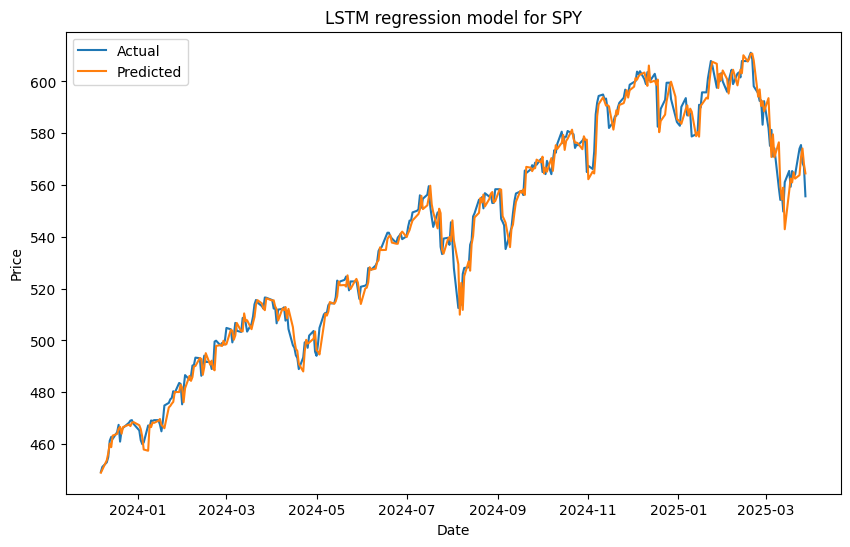

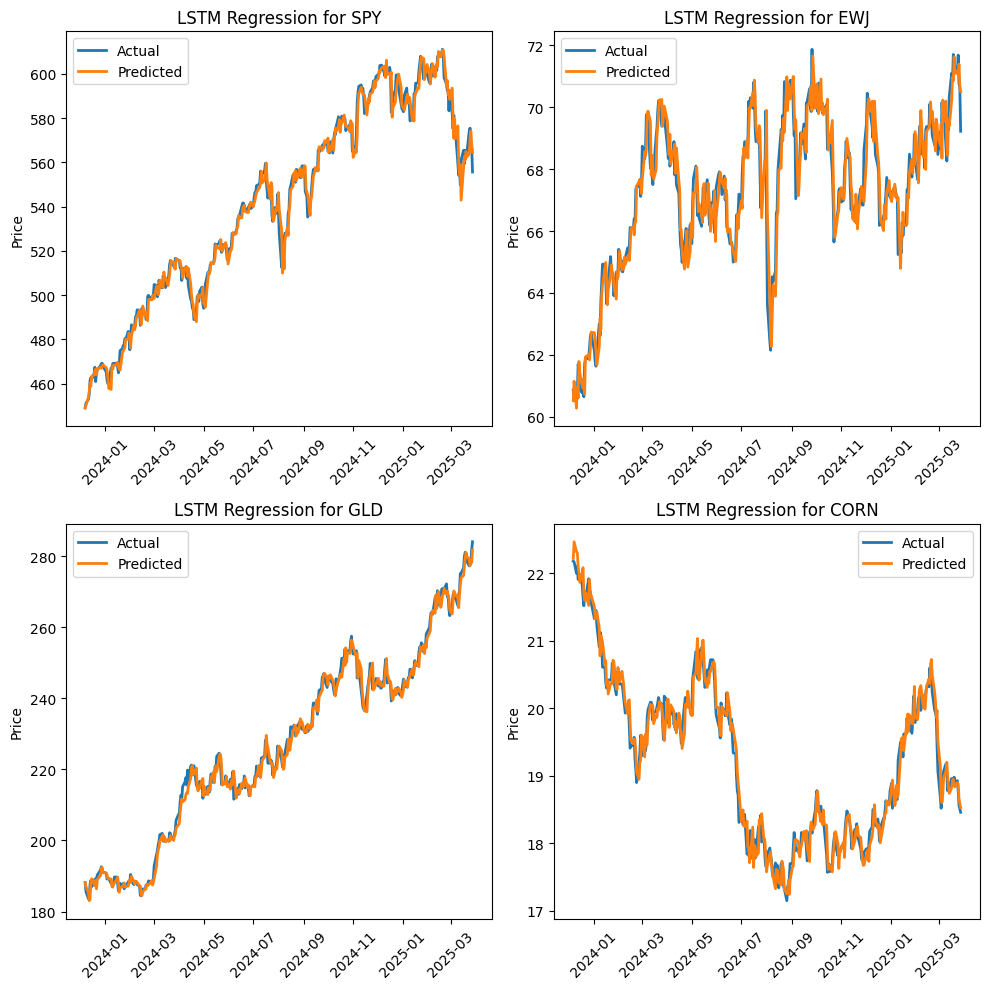

In [21]:
y_test_denorm = y_test * first_prices_test
print(f"y_test_denorm shape: {y_test_denorm.shape}")
y_test_denorm= y_test_denorm[-test_size:]
y_actual = pd.DataFrame(y_test_denorm, index=data.index[-test_size::], columns=data.columns)
display(predicted_prices)
ticker_name = 'SPY'

plt.figure(figsize=(10,6))
plt.plot(y_actual[ticker_name], label='Actual')
plt.plot(predicted_prices[ticker_name], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM regression model for {ticker_name}')
plt.legend()
plt.show()


ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  # example tickers, adjust as needed

# Define layout
num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten()  # Flatten in case of single row

# Plot each ticker
for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(predicted_prices[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

# Remove any empty subplots if the number of tickers is less than the number of subplots
for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [ ]:
yesterday_prices = data.iloc[-2]  # second last row 

today_prices_actual = data.iloc[-1] # last row

today_prices_predicted = predicted_prices.mean(axis=0)  

comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_pred': today_prices_predicted,
})

tickers_names = data.columns

correct_list = []
for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]

    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)

    if sign_actual == sign_pred:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list

count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
display(comparison_df)
save_df = comparison_df.copy()
save_df['Yesterday actual'] = save_df['Yesterday_actual'].apply(lambda x: round(x, 2))
save_df['Today actual'] = save_df['Today_actual'].apply(lambda x: round(x, 2))
save_df['Today prediction'] = save_df['Today_pred'].apply(lambda x: round(x, 2))
save_df['Correct'] = save_df['Correct'].apply(lambda x: round(x, 2))
save_df.to_csv('rf_regression.csv')


Count of correct predictions: 22
accuracy: 0.6666666666666666


,Yesterday_actual,Today_actual,Today_pred,Correct
AIEQ,37.658001,36.845001,37.007463,1
ASHR.L,10.460000,10.340000,9.578683,1
BCHN.L,97.080002,92.714996,96.145670,1
CORN,18.510000,18.459999,19.257366,0
DBO,14.130000,13.970000,14.216009,0
EDEN,105.330002,105.169998,117.581202,0
EMXC,56.110001,55.180000,56.490125,0
EWA,23.750000,23.469999,24.171452,0
EWC,41.250000,40.570000,38.532941,1
EWG,37.590000,37.389999,31.698514,1
